
### [40 %] Train the models and present result of your work
- Use the models introduced during the course, which are relevant for the task you are solving
- You are supposed to compare at least 3 models
- Tune (or explain why there is no need to tune) hyperparameters of each model
- Use cross-validation to compare models and select hyperparameters
- Which model and setup is the best? How does it perform on the test dataset? 

# Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from warnings import filterwarnings
filterwarnings('ignore')


# Formalising the task and suggesting the evaluation criterion

As it is generally taught during all our statistics courses at HSE, it is better to formulate your hypothesis and only then start working with the data. That's why the only thing we are interested right now are the feautres that are available to us.

We will ignore distributions for now, and will run a simple EDA to check the data - features and their types, missing values, etc.

In [2]:
# import data
movies = pd.read_csv("imdb_movies.csv") # had to filter the year by 1975+ to fit to github


In [31]:
# check features & types
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60198 entries, 0 to 60197
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          60198 non-null  object 
 1   title                  60198 non-null  object 
 2   original_title         60198 non-null  object 
 3   year                   60198 non-null  int64  
 4   date_published         60198 non-null  object 
 5   genre                  60198 non-null  object 
 6   duration               60198 non-null  int64  
 7   country                60193 non-null  object 
 8   language               59718 non-null  object 
 9   director               60174 non-null  object 
 10  writer                 59390 non-null  object 
 11  production_company     57454 non-null  object 
 12  actors                 60168 non-null  object 
 13  description            58205 non-null  object 
 14  avg_vote               60198 non-null  float64
 15  vo

### `What is your target variable?`

The target variable is the avg_vote column. It is a continuous variable. I'll try to utilize the regression models to predict the average vote mark for the movie.

### `Why is it a good measure of success and how the film-producing company can use it to make their decision?`
There are two potential benefits for the companies. 
- First, they can use the model to predict the success of the movie before it is released. This will cut off the costs of the movie production by removing the movies that are predicted to be unsuccessful (and given that they are going to be too costly)
- Second, they can research the features that are the most important for the success of the movie. This will allow them to focus on the features that weigh the most, potentially increasing revenue.

### `Which task are you going to solve (is it a regression, classification or something else)?`
The goal is to to solve the regression task. The target variable is continuous, and the task is to predict the value of the target variable.


### `Which metric will you use to evaluate the performance of the model? Do you have any idea, which values of the metrics can be considered good enough?`
We are very interested in both cutting the costs and increasing renevue, thats why two metrics come to mind:
- $MAE$ - mean absolute error. This metric will show us the average error of the model. MAE is easy to interpret, and it ignores the direction of the error. This is important, because we are interested in the absolute value of the error, not the direction of it. Cutting costs on the potentially successful movie is as bad as investing in the potentially unsuccessful movie.
- $R^2$. The coefficient of determination is widespread & easy to interpret, and it is a good measure of the model's performance, especially when you are interested in discussing to what extent features cover the variance of the target variable.

```python
movies.avg_vote.describe() # gotta run this to determine the range of the target variable
```

    count    60198.000000
    mean         5.997349
    std          1.199483
    min          1.000000
    25%          5.400000
    50%          6.200000
    75%          6.800000
    max         10.000000
    Name: avg_vote, dtype: float64


Based on the description of the target variable, I think that the MAE of $1$ is a OK-ish. This would mean that the model is off by 1 point on average. This is not a very good result, but it is a good starting point, especially since votes for movies are rather subjective.

# Explore and preprocess the data

In [32]:
# udfs

def plot_distribution(df, column, bins=20, transform=None):
    """
    Plot distribution of data in a column
    """
    transforms = ['log', 'sqrt', 'square', 'exp', None]
    if transform is not None:
        assert transform in transforms, "transform must be in {}".format(transforms)
        plt.hist(df[column].apply(transform), bins=bins)
    else:
        plt.hist(df[column], bins=bins)
    plt.title(column)
    plt.show()


In [33]:
# splitting data
target = ['avg_vote']

y_train, y_test = train_test_split(movies[target], test_size=0.2, random_state=42)
X_train, X_test = train_test_split(movies.drop(target, axis=1), test_size=0.2, random_state=42)

Let us start the EDA by checking the number of categorical and numerical features.

In [34]:
# num of numeric & categorical features
num_features = X_train.select_dtypes(include=np.number).columns
cat_features = X_train.select_dtypes(exclude=np.number).columns

print(f"Number of numeric features: {len(num_features)}")
print(f"Number of categorical features: {len(cat_features)}\n")

print(f'num features: {[_ for _ in num_features]}')
print(f'cat features: {[_ for _ in cat_features]}')

Number of numeric features: 6
Number of categorical features: 15

num features: ['year', 'duration', 'votes', 'metascore', 'reviews_from_users', 'reviews_from_critics']
cat features: ['imdb_title_id', 'title', 'original_title', 'date_published', 'genre', 'country', 'language', 'director', 'writer', 'production_company', 'actors', 'description', 'budget', 'usa_gross_income', 'worlwide_gross_income']


Now, let us check missing values, and remove those features that have too many missing of those.

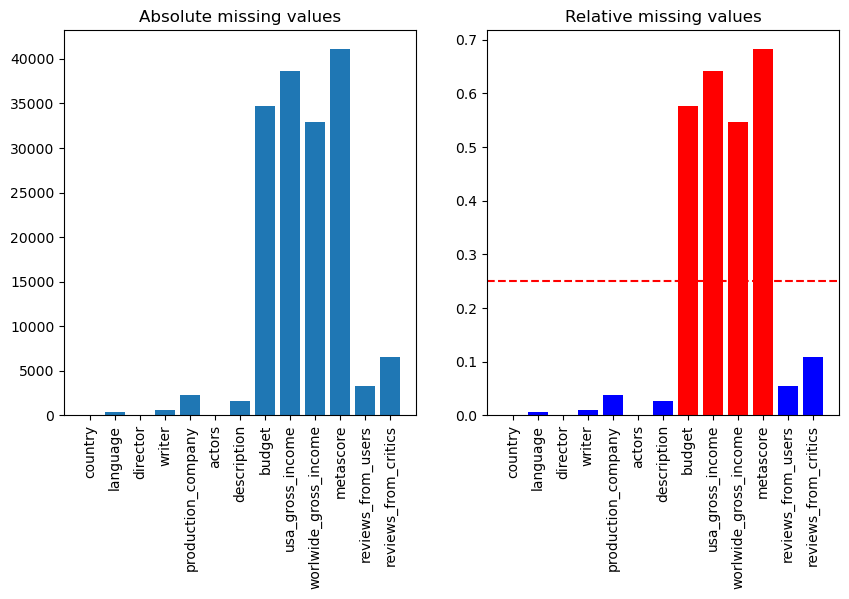

In [35]:
# plot absolute and relative missing values
missing = X_train.isnull().sum()
missing = missing[missing > 0]
missing_rel = missing / len(movies)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
color = ["red" if x > 0.25 else "blue" for x in missing_rel]
ax[0].bar(missing.index, missing)
ax[1].bar(missing.index, missing_rel, color=color)
ax[0].set_xticklabels(missing.index, rotation=90)
ax[1].set_xticklabels(missing.index, rotation=90)
ax[1].axhline(y=0.25, color="red", linestyle="--")
ax[0].set_title("Absolute missing values")
ax[1].set_title("Relative missing values")
plt.show()


# drop columns with more than 25% of missing values
missing_rel = missing_rel[missing_rel > 0.25]
X_train = X_train.drop(missing_rel.index, axis=1)


Let us check for missing values in the remaining columns.

In [36]:
# check na, order by number of na 
X_train.isnull().sum().sort_values(ascending=False)

reviews_from_critics    6589
reviews_from_users      3278
production_company      2223
description             1572
writer                   640
language                 392
actors                    22
director                  19
country                    4
duration                   0
title                      0
genre                      0
date_published             0
year                       0
votes                      0
original_title             0
imdb_title_id              0
dtype: int64

Now, we need to fill the missing values in the remaining columns. We will use the SimpleImputer from sklearn for this task.

The defined imputer is used later within the pipeline.

In [37]:
# imputer for numeric and categorical features
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

To remove the irrelevant features, we can check for
- variance of numeric features; when $Var = 0$, the feature is constant and can be removed
- number of unique values in categorical features; when $n_{unique} = 1$, the feature is constant and can be removed
- correlation between features; high correlation between features indicates that they are redundant

In [38]:
# assert non-zero variance
num_features = X_train.select_dtypes(include=np.number).columns
variance = X_train[num_features].var()
assert (variance > 0).all(), "There are features with zero variance"

In [39]:
# check for constant categorical features
cat_features = X_train.select_dtypes(exclude=np.number).columns
constant = X_train[cat_features].nunique()
assert (constant > 1).all(), "There are constant categorical features"

In [40]:
# check for correlations
corr = X_train[num_features].corr()
corr

,year,duration,votes,reviews_from_users,reviews_from_critics
year,1.000000,0.184083,0.100812,0.102101,0.193890
duration,0.184083,1.000000,0.131298,0.139211,0.143898
votes,0.100812,0.131298,1.000000,0.846206,0.672489
reviews_from_users,0.102101,0.139211,0.846206,1.000000,0.723834
reviews_from_critics,0.193890,0.143898,0.672489,0.723834,1.000000


We can drop some irrelevant features that certain will not imporve the model score. For instance, `movie titles` or `description`.

In [41]:
# dropping redundant features
X_train = X_train.drop(['imdb_title_id', 'title', 'original_title', 'description', 'date_published'], axis=1)

Given the very high cardinality of categorical features, we can encode them as binary features. This will increase the number of features, since we can use top-n approach.

Now we can define a transformation pipeline.

In [42]:
num_features = X_train.select_dtypes(include=np.number).columns
cat_features = X_train.select_dtypes(exclude=np.number).columns

# pipe for numeric features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# pipe for categorical features
cat_pipeline = Pipeline([
    ('imputer', cat_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# final pipe
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
], remainder='passthrough')

I'll test 3 models for this task:
- Ridge regression
- Gradient boosting
- Support vector regression

In [43]:
# Let's start with a simple ridge regression
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


# cross validation on 5 folds, mae
mae_rigde = cross_val_score(pipe_ridge, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Mean MAE: {-mae_rigde.mean():.3f} +/- {mae_rigde.std():.3f}")

# cv on 5 folds, r^2
r2_ridge = cross_val_score(pipe_ridge, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R^2: {r2_ridge.mean():.3f} +/- {r2_ridge.std():.3f}")

Mean MAE: 0.635 +/- 0.003
Mean R^2: 0.501 +/- 0.011


In [44]:
# lets proceed with the SVM model
pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# cross validation on 5 folds, mae
mae_svr = cross_val_score(pipe_svr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Mean MAE: {-mae_svr.mean():.3f} +/- {mae_svr.std():.3f}")

# cv on 5 folds, r^2
r2_svr = cross_val_score(pipe_svr, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R^2: {r2_svr.mean():.3f} +/- {r2_svr.std():.3f}")

In [ ]:
# Finally, let's try a gradient boosting
pipe_grad = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=10, random_state=42))
])

# cross validation on 5 folds, mae
mae_grad = cross_val_score(pipe_grad, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Mean MAE: {-mae_grad.mean():.3f} +/- {mae_grad.std():.3f}")

# cv on 5 folds, r^2
r2_grad = cross_val_score(pipe_grad, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R^2: {r2_grad.mean():.3f} +/- {r2_grad.std():.3f}")


Mean MAE: 0.787 +/- 0.004
Mean R^2: 0.272 +/- 0.005


Let us now run the pipeline on the test data.

In [ ]:
for model in [pipe_ridge, pipe_grad, pipe_svr]:
    model.fit(X_train, y_train)
    model_name = model.named_steps['regressor'].__class__.__name__

    y_pred = model.predict(X_test)
    print(f"MAE for {model_name}: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"R^2 for {model_name}: {r2_score(y_test, y_pred):.3f}")
    print('')

As we can see, MAE-wise simple Ridge regression performs quite good. Although the R^2 is rather low (around 0.5), it can be explained by the fact that the target variable is not normally distributed and that features in our data do not fully cover the scope to predict `avg_score`.

# Performance tuning

The block below permorms the grid search for the hyperparameters of the models. The grid search is performed on the training data, and the best model is selected based on the MAE score.

I tried running it on the whole dataset, but eventually (and rather expectedly) I get OOM error. My company prohibited me from running it in Azure, sorry:(


In [2]:
# grid search for ridge
param_grid = {
    'regressor__alpha': [0.1, 1, 10, 100],
    'regressor__solver': ['svd', 'cholesky', 'lsqr']
}
grid_ridge = GridSearchCV(pipe_ridge, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_ridge.fit(X_train, y_train)


# grid search for gradient boosting
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7]
}
grid_grad = GridSearchCV(pipe_grad, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_grad.fit(X_train, y_train)


# grid search for svm
param_grid = {
    'regressor__C': np.logspace(-3, 3, 7),
    'regressor__kernel': ['linear', 'poly', 'rbf'],
    'regressor__gamma': np.logspace(-3, 3, 7)
}
grid_svr = GridSearchCV(pipe_svr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_svr.fit(X_train, y_train)

# best params & score for ridge
print(grid_ridge.best_params_)
print(grid_ridge.best_score_)

# best params for gradient boosting
print(grid_grad.best_params_)
print(grid_grad.best_score_)

# best params for svm
print(grid_svr.best_params_)
print(grid_svr.best_score_)

# determine best model
best_model_ridge, best_model_grad, best_model_svr = grid_ridge.best_estimator_, grid_grad.best_estimator_, grid_svr.best_estimator_

# final evaluation
for model in [best_model_ridge, best_model_grad, best_model_svr]:
    model.fit(X_train, y_train)
    model_name = model.named_steps['regressor'].__class__.__name__

    y_pred = model.predict(X_test)
    print(f"MAE for {model_name}: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"R^2 for {model_name}: {r2_score(y_test, y_pred):.3f}")
    print('')

MemoryError: 

Although the $R^2$ score of my models is not very high, the MAE is quite low. This means that the model is off by 0.5-1 point on average. This is a good result, given that we don't have too many features to predict the target variable. I guess one good adjustment would be to perform a more thorough feature engineering, and to add more features to the dataset (if the latter is possible).


Thanks for a cool course!